In [1]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

def compute_features(row):
    rownp = row.to_numpy()
    return [np.sum(rownp),                        # NPE
            np.nonzero(rownp)[0].shape[0],        # NActiveSlices
            np.mean(rownp),                       # Mean NPE
            np.std(rownp),                        # Std NPE
            np.nonzero(rownp)[0][-1] - np.nonzero(rownp)[0][0] + 1,    # Range
            np.var(np.repeat(np.argwhere(rownp>0), rownp[rownp>0])),   # Var
            np.std(np.repeat(np.argwhere(rownp>0), rownp[rownp>0]))]   # Var   


In [2]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [3]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [4]:
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "Ar39_07_09_2020", "Ar39_Snapshots")
fileinprefix = "Snapshot1Ar39*.csv"

df_ar39 = load_dataframe_from_files(dirin, fileinprefix, max_files=100)
df_ar39 = df_ar39[df_ar39.pedetected>0]
df_ar39 = df_ar39[df_ar39.columns[:-1]]

[Info] Loading 100 files wt prefix:
Snapshot1Ar39*.csv
...................................................................................................


In [5]:
dirin = os.path.join("..", "..", "Data", "OutputProcessing", "Muons_07_09_2020", "Muons_Snapshots")
fileinprefix = "SnapshotMuon*.csv"

df_mu = load_dataframe_from_files(dirin, fileinprefix, max_files=200)
df_mu = df_mu[df_mu.pedetected>0]
df_mu = df_mu[df_mu.columns[:-1]]

[Info] Loading 200 files wt prefix:
SnapshotMuon*.csv
.......................................................................................................................................................................................................


In [10]:
minPEcut, maxPEar39 = 5, df_ar39.pedetected.max()
df_lear39 = df_ar39[(df_ar39.pedetected >= minPEcut) & (df_ar39.pedetected <= maxPEar39)]
df_lemu = df_mu[(df_mu.pedetected >= minPEcut) & (df_mu.pedetected <= maxPEar39)]
print("[Info] Loaded {} Ar39 decays, with maximum {} PE detected".format(len(df_lear39), maxPEar39))
print("[Info] Selected {} Muons, with maximum {} PE detected".format(len(df_lemu), df_lemu.pedetected.max()))

[Info] Loaded 1474688 Ar39 decays, with maximum 60 PE detected
[Info] Selected 5110 Muons, with maximum 60 PE detected


## Remove Test Data for later evaluation

In [11]:
# Remove test data for later eval
n_test_mu, n_test_ar = 610, 1000000
# split mu data
id_mu = np.arange(len(df_lemu))
np.random.shuffle(id_mu)
muons_test, muons_train = df_lemu.iloc[id_mu[:n_test_mu], :], df_lemu.iloc[id_mu[n_test_mu:], :]
# split ar39 data
id_ar = np.arange(len(df_lear39))
np.random.shuffle(id_ar)
ar39_test, ar39_train = df_lear39.iloc[id_ar[:n_test_ar], :], df_lear39.iloc[id_ar[n_test_ar:], :]
print("[Info] Muon Train {}, Test {}".format(len(muons_train), len(muons_test)))
print("[Info] Ar39 Train {}, Test {}".format(len(ar39_train), len(ar39_test)))

[Info] Muon Train 4500, Test 610
[Info] Ar39 Train 474688, Test 1000000


### Undersample Ar39

In [12]:
def undersample_argon(ar39_df, number_of_instances=1000, augment_from_pe=35, augmentation_nr=5,
                      skip_first_cols=2, nslices=72):
    bins = np.linspace(0, 61, 62)
    bin_cont, bin_edges, _ = plt.hist(ar39_df.pedetected, bins=bins, density=True, label="1Ar39", edgecolor='w')
    # compute the nr of samples for each PE value,
    # to undersample ar39 keeping the same distribution
    avail_instances_per_pe = np.array([len(ar39_df[ar39_df.pedetected==pe]) for pe in range(61)])
    nr_ar_samples_per_pe = np.array(np.where(np.ceil(bin_cont*number_of_instances)<=avail_instances_per_pe, np.ceil(bin_cont*number_of_instances), 0), dtype=int)
    # Introduce a small bias on instances with "high" PE value
    # to avoid to have just a few samples (e.g. 30,40,50,60 PE)
    scaled_ar39 = pd.DataFrame()
    for pe in range(1, 61):
        if pe > augment_from_pe:
            nr_instances = augmentation_nr
        else:
            nr_instances = nr_ar_samples_per_pe[pe]
        scaled_ar39 = pd.concat([scaled_ar39, ar39_df[ar39_df.pedetected==pe].iloc[:nr_instances]])
    AA = scaled_ar39.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    np.random.shuffle(AA)    # to avoid order by PE
    return pd.DataFrame(AA)

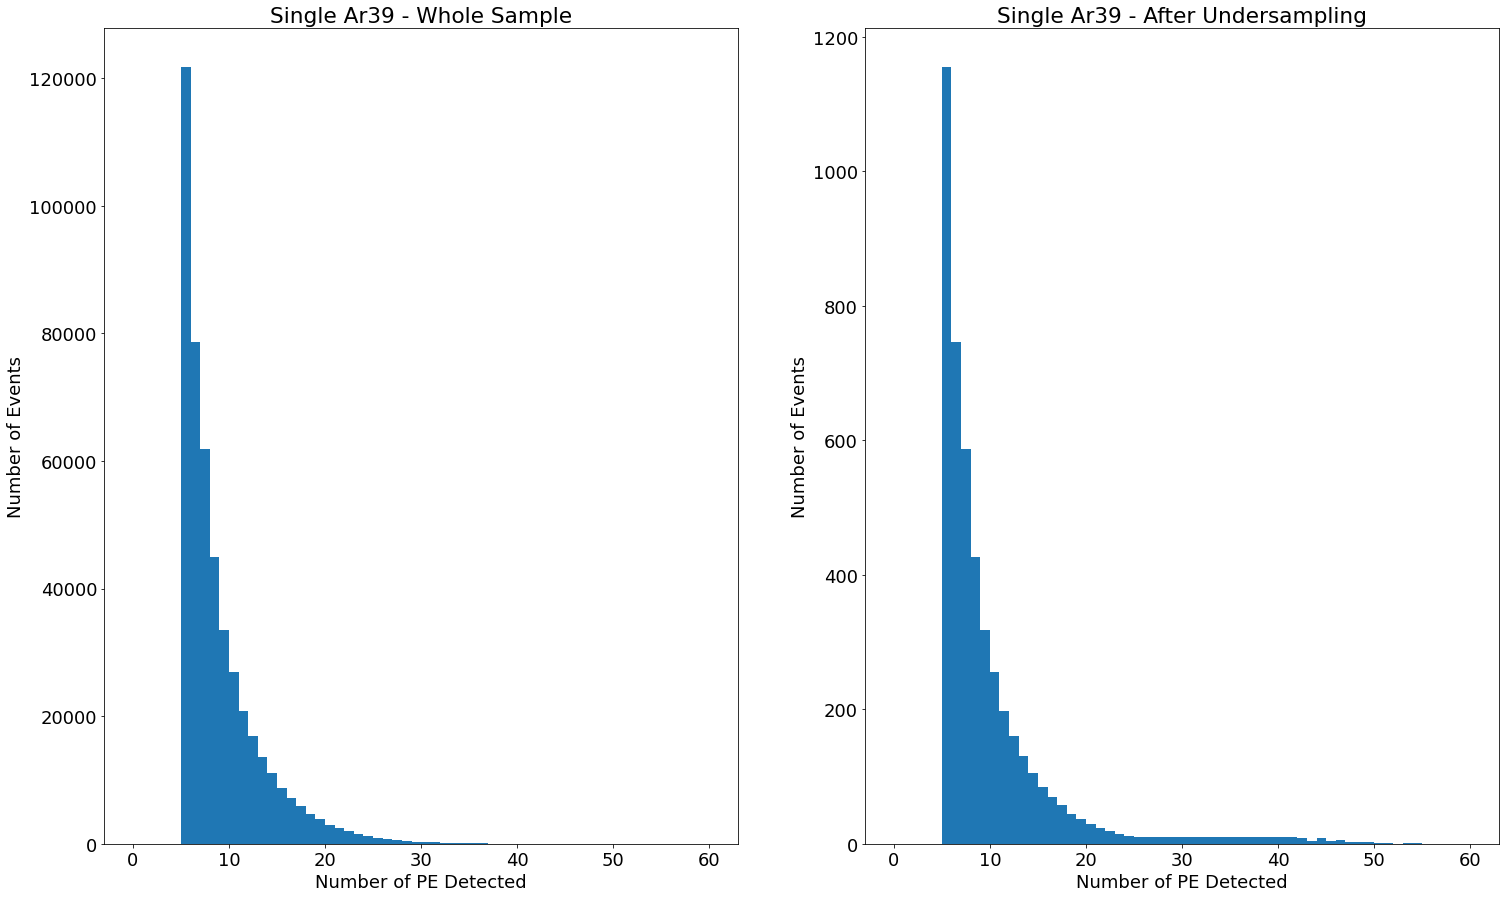

[Info] Undersample Ar39: 4683 instances


In [20]:
n_inner_slices, n_outer_slices = 12, 20

sampled_ar39 = undersample_argon(ar39_train, len(muons_train), augment_from_pe=25, augmentation_nr=10, skip_first_cols=3, nslices=n_inner_slices+n_outer_slices)
plt.cla()
plt.subplot(1, 2, 1)
plt.title("Single Ar39 - Whole Sample")
plt.xlabel("Number of PE Detected")
plt.ylabel("Number of Events")
plt.hist(ar39_train.pedetected, bins=np.linspace(0, 60, 61), label="All 1 Ar39 Events")

plt.subplot(1, 2, 2)
plt.hist(sampled_ar39.sum(axis=1), bins=np.linspace(0, 60, 61), label="Undersampled 1 Ar39")
plt.title("Single Ar39 - After Undersampling")
plt.xlabel("Number of PE Detected")
plt.ylabel("Number of Events")
plt.show()

print("[Info] Undersample Ar39: {} instances".format(sampled_ar39.shape[0]))

In [10]:
# Compute features muon
import time

init = time.time()
mu_feat = pd.DataFrame()
mu_feat["PEDetected_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
mu_feat["NActiveSlices_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_feat["MeanNPEActive_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
mu_feat["StdNPEActive_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
mu_feat["SpatialRange_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
mu_feat["SpatialVar_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
mu_feat["SpatialStd_inner"] = muons_train.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
mu_feat["PEDetected_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
mu_feat["NActiveSlices_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_feat["MeanNPEActive_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
mu_feat["StdNPEActive_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
mu_feat["SpatialRange_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
mu_feat["SpatialVar_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
mu_feat["SpatialStd_outer"] = muons_train.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
mu_feat["PEDetected_tot"] = mu_feat["PEDetected_inner"] + mu_feat["PEDetected_outer"]
mu_feat["NActiveSlices_tot"] = mu_feat["NActiveSlices_inner"] + mu_feat["NActiveSlices_outer"]
mu_feat["MeanNPEActive_tot"] = mu_feat["PEDetected_tot"] / mu_feat["NActiveSlices_tot"]
mu_feat = mu_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

init = time.time()
ar39_feat = pd.DataFrame()
ar39_feat["PEDetected_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
ar39_feat["NActiveSlices_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar39_feat["MeanNPEActive_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
ar39_feat["StdNPEActive_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
ar39_feat["SpatialRange_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
ar39_feat["SpatialVar_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
ar39_feat["SpatialStd_inner"] = sampled_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
ar39_feat["PEDetected_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
ar39_feat["NActiveSlices_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar39_feat["MeanNPEActive_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
ar39_feat["StdNPEActive_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
ar39_feat["SpatialRange_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
ar39_feat["SpatialVar_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
ar39_feat["SpatialStd_outer"] = sampled_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar39 Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
ar39_feat["PEDetected_tot"] = ar39_feat["PEDetected_inner"] + ar39_feat["PEDetected_outer"]
ar39_feat["NActiveSlices_tot"] = ar39_feat["NActiveSlices_inner"] + ar39_feat["NActiveSlices_outer"]
ar39_feat["MeanNPEActive_tot"] = ar39_feat["PEDetected_tot"] / ar39_feat["NActiveSlices_tot"]
ar39_feat = ar39_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 0.669 sec
Compute Mu Outer features: 0.892 sec
Compute combined features: 0.005 sec
Compute Ar39 Inner features: 0.861 sec
Compute Ar39 Outer features: 0.897 sec
Compute combined features: 0.003 sec


# Try to simplify the features
Motivation: std dev, var are computationally expensive, PEDetected is a sum, Range is a difference. They could fit better the real-time setting.

In [11]:
my_features = ["PEDetected_inner", "NActiveSlices_inner", "MeanNPEActive_inner", "SpatialRange_inner", 
               "PEDetected_outer", "NActiveSlices_outer", "MeanNPEActive_outer", "SpatialRange_outer", 
               "PEDetected_tot", "NActiveSlices_tot"]

print("\nBased on this data, and the correlation matrix. I propose the following features:")
for feat in my_features:
    print("{}".format(feat), end=", ")
print()

mu_myfeat = mu_feat.loc[:, my_features]
ar39_myfeat = ar39_feat.loc[:, my_features]


Based on this data, and the correlation matrix. I propose the following features:
PEDetected_inner, NActiveSlices_inner, MeanNPEActive_inner, SpatialRange_inner, PEDetected_outer, NActiveSlices_outer, MeanNPEActive_outer, SpatialRange_outer, PEDetected_tot, NActiveSlices_tot, 


## Train DTree on these features

In [12]:
from sklearn.metrics import make_scorer
def my_custom_score_func(y_true, y_pred):
    tn, fp, fn, tp = cv(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return 1 * (1-fpr) + 0 * tpr
my_score = make_scorer(my_custom_score_func, greater_is_better=True)

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix as cv
import time

init = time.time()

# Prepare data for training
mu_myfeat["y"] = 1
ar39_myfeat["y"] = 0
data = pd.concat([mu_myfeat, ar39_myfeat], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = np.array(X)
y = np.array(y)

score = "accuracy"
print("[Info] Tune criterion")
parameters = {'criterion': ['gini', 'entropy']}        

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(DecisionTreeClassifier(max_depth=4, min_samples_leaf=1), 
                   param_grid = parameters, 
                   scoring=score, n_jobs=2, cv=5)

# Fit the grid search
clf.fit(X, y)
best_criterion = clf.best_params_["criterion"]
print("Best Criterion: {} => Score: {}".format(best_criterion, clf.best_score_))


print("\n[Info] Tune Depth, Min Samples leaf")
parameters = {'min_samples_leaf': [300, 400, 500, 600, 700, 800, 900, 1000]}    

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(DecisionTreeClassifier(criterion=best_criterion, max_depth=4), 
                   param_grid = parameters, 
                   scoring=score, n_jobs=2, cv=5)
# Fit the grid search
clf.fit(X, y)
best_minleaf = clf.best_params_["min_samples_leaf"]
print("Best Min Samples Leaf: {} => Score: {}".format(best_minleaf, clf.best_score_))

parameters = {'max_depth': [2, 3, 4]}
clf = GridSearchCV(DecisionTreeClassifier(criterion=best_criterion, min_samples_leaf=best_minleaf), 
                   param_grid = parameters, 
                   scoring=score, n_jobs=2, cv=5)
# Fit the grid search
clf.fit(X, y)
best_max_depth = clf.best_params_["max_depth"]
print("Best Max Depth: {} => Score: {}".format(best_max_depth, clf.best_score_))

print("\n[Info] Best Model Evaluation")
# Use Cross Validation To Evaluate Final Model
print("[Model] Criterion: {}, Max Depth: {}, Min Samples Leaf: {}".format(best_criterion,
                                                                         best_max_depth,
                                                                         best_minleaf))
final_clf = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth,
                            min_samples_leaf=best_minleaf)
#final_clf.fit(X, y)
CV_Result = cross_val_score(final_clf, X, y, cv=5, scoring=my_score)
print("[Results]\n\t5-Fold X-Validation: {}".format(CV_Result))
print("\tMean Score: {:.4f}, Std Dev: {:.4f}".format(CV_Result.mean(), CV_Result.std()))

print("[Time] Elapsed time {}".format(time.time() - init))

[Info] Tune criterion
Best Criterion: entropy => Score: 0.8906588812098428

[Info] Tune Depth, Min Samples leaf
Best Min Samples Leaf: 400 => Score: 0.8792007042169636
Best Max Depth: 4 => Score: 0.8792007042169636

[Info] Best Model Evaluation
[Model] Criterion: entropy, Max Depth: 4, Min Samples Leaf: 400
[Results]
	5-Fold X-Validation: [0.89174705 0.87031083 0.89924973 0.88210075 0.88304721]
	Mean Score: 0.8853, Std Dev: 0.0098
[Time] Elapsed time 0.9141249656677246


Feature: PEDetected_inner =>	Score: 0.20037
Feature: NActiveSlices_inner =>	Score: 0.06303
Feature: PEDetected_outer =>	Score: 0.09094
Feature: NActiveSlices_outer =>	Score: 0.51009
Feature: SpatialRange_outer =>	Score: 0.10938
Feature: PEDetected_tot =>	Score: 0.02619


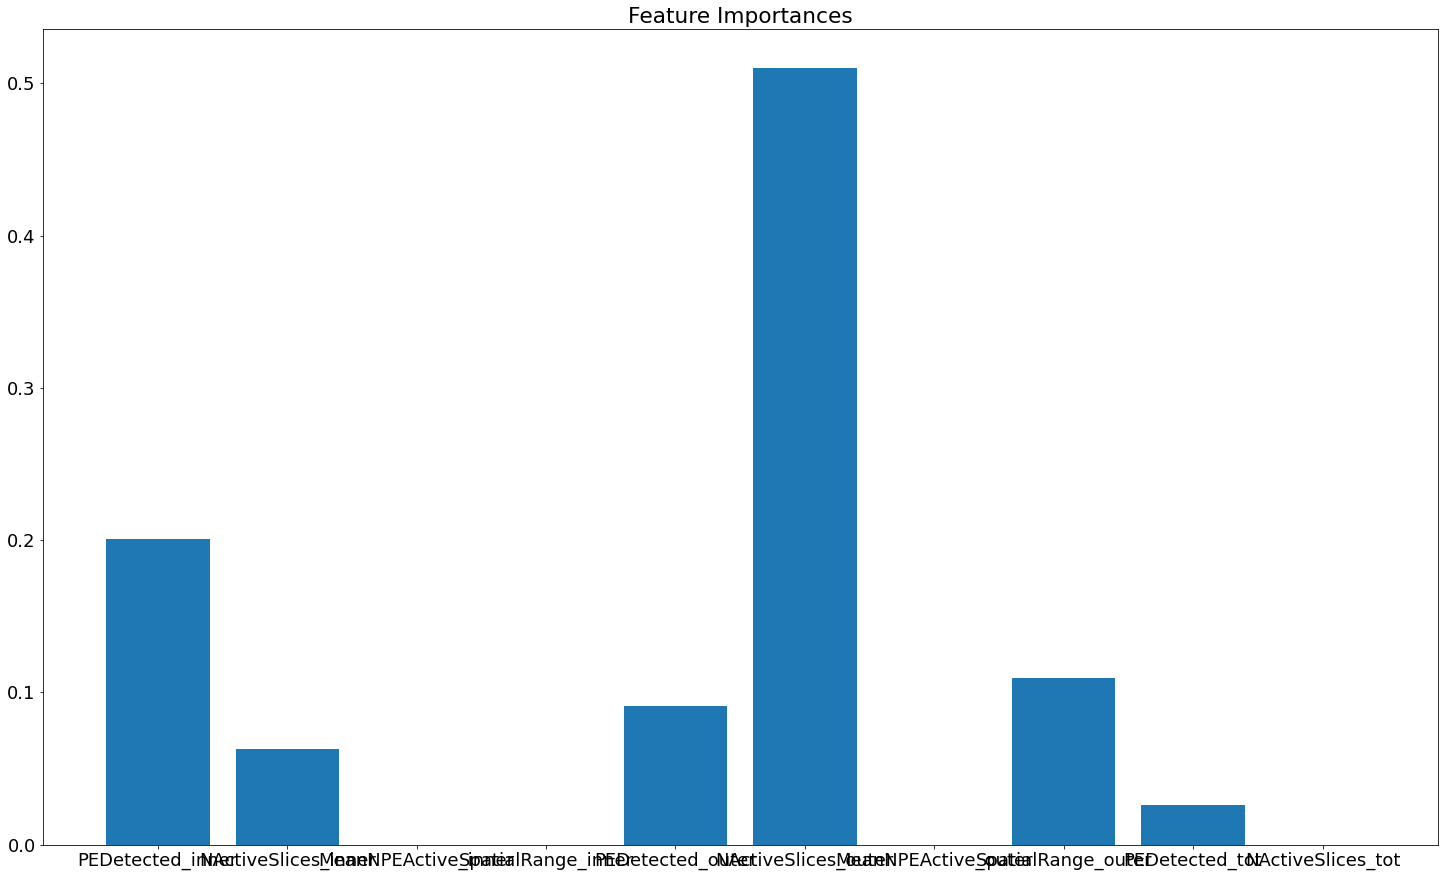

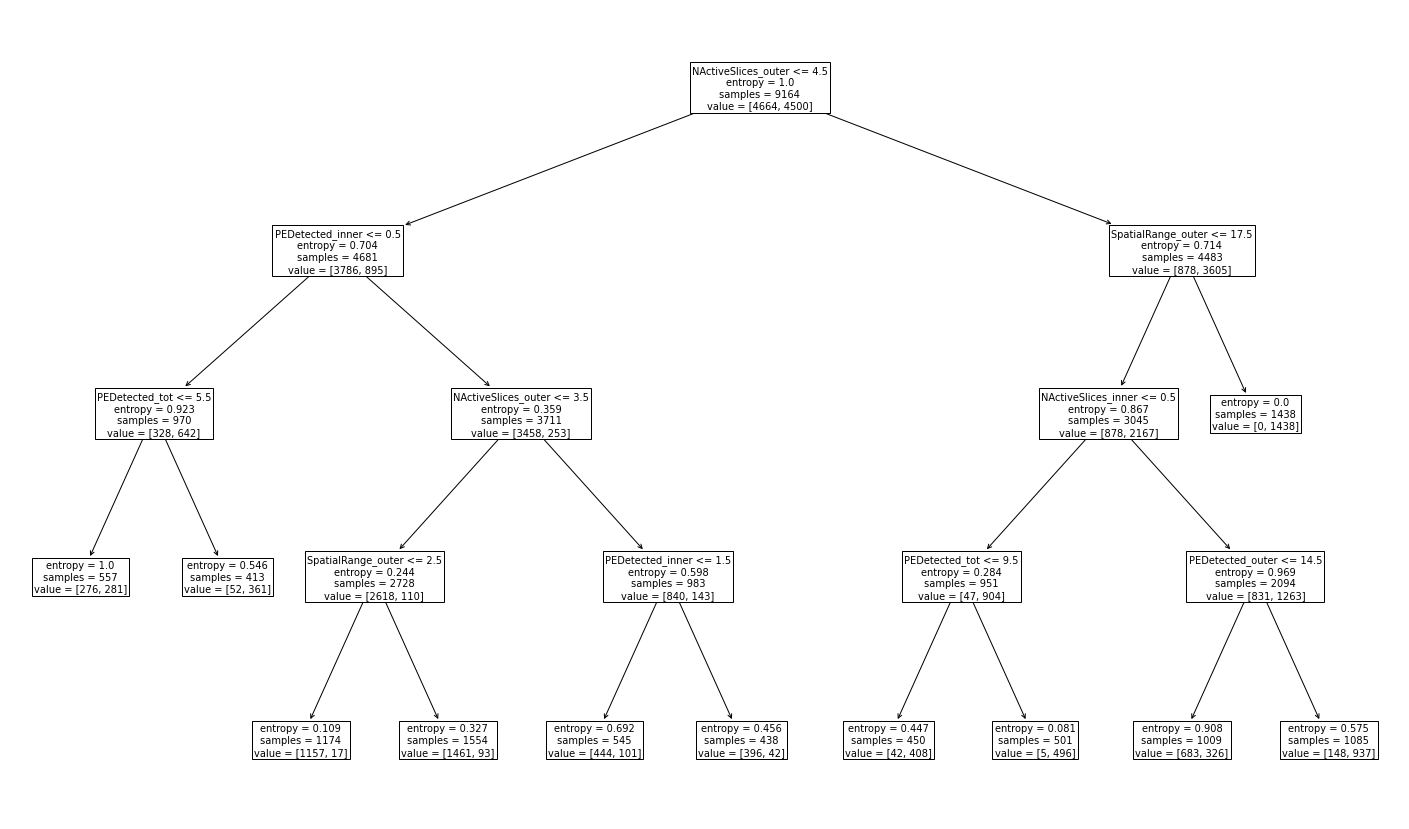

In [14]:
from sklearn import tree
# Train final model
final_clf = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth,
                            min_samples_leaf=best_minleaf)
final_clf.fit(X, y)

full_feature_names = ar39_myfeat.columns[:-1]
short_feature_names = full_feature_names
# get importance
importances = final_clf.feature_importances_
# summarize feature importance
for i, (name, shortn, v) in enumerate(zip(full_feature_names, short_feature_names, importances)):
    if(v<=0): 
        continue
    print('Feature: %s =>\tScore: %.5f' % (name, v))
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.xticks(range(0, len(short_feature_names)), short_feature_names)
plt.title("Feature Importances")
plt.show()

tree.plot_tree(final_clf, feature_names=ar39_myfeat.columns[:-1])
plt.show()

## Evaluate DTree on Test Data

In [15]:
# Prepare data
init = time.time()

init = time.time()
mu_test_feat = pd.DataFrame()
mu_test_feat["PEDetected_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
mu_test_feat["NActiveSlices_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_test_feat["MeanNPEActive_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
mu_test_feat["StdNPEActive_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
mu_test_feat["SpatialRange_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
mu_test_feat["SpatialVar_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
mu_test_feat["SpatialStd_inner"] = muons_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
mu_test_feat["PEDetected_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
mu_test_feat["NActiveSlices_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
mu_test_feat["MeanNPEActive_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
mu_test_feat["StdNPEActive_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
mu_test_feat["SpatialRange_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
mu_test_feat["SpatialVar_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
mu_test_feat["SpatialStd_outer"] = muons_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
mu_test_feat["PEDetected_tot"] = mu_test_feat["PEDetected_inner"] + mu_test_feat["PEDetected_outer"]
mu_test_feat["NActiveSlices_tot"] = mu_test_feat["NActiveSlices_inner"] + mu_test_feat["NActiveSlices_outer"]
mu_test_feat["MeanNPEActive_tot"] = mu_test_feat["PEDetected_tot"] / mu_test_feat["NActiveSlices_tot"]
print("Compute Mu Combined features: {:.3f} sec".format(time.time() - init))

init = time.time()
ar_test_feat = pd.DataFrame()
ar_test_feat["PEDetected_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
ar_test_feat["NActiveSlices_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar_test_feat["MeanNPEActive_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
ar_test_feat["StdNPEActive_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
ar_test_feat["SpatialRange_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
ar_test_feat["SpatialVar_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
ar_test_feat["SpatialStd_inner"] = ar39_test.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar features: {:.3f} sec".format(time.time() - init))
init = time.time()
ar_test_feat["PEDetected_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
ar_test_feat["NActiveSlices_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
ar_test_feat["MeanNPEActive_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
ar_test_feat["StdNPEActive_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
ar_test_feat["SpatialRange_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
ar_test_feat["SpatialVar_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
ar_test_feat["SpatialStd_outer"] = ar39_test.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar features: {:.3f} sec".format(time.time() - init))
ar_test_feat["PEDetected_tot"] = ar_test_feat["PEDetected_inner"] + ar_test_feat["PEDetected_outer"]
ar_test_feat["NActiveSlices_tot"] = ar_test_feat["NActiveSlices_inner"] + ar_test_feat["NActiveSlices_outer"]
ar_test_feat["MeanNPEActive_tot"] = ar_test_feat["PEDetected_tot"] / ar_test_feat["NActiveSlices_tot"]
print("Compute Ar Combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 0.102 sec
Compute Mu Inner features: 0.128 sec
Compute Mu Combined features: 0.130 sec
Compute Ar features: 181.883 sec
Compute Ar features: 192.509 sec
Compute Ar Combined features: 192.521 sec


In [16]:
mu_test_feat = mu_test_feat.fillna(-1)
ar_test_feat = ar_test_feat.fillna(-1)

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cv

# Test model
init = time.time()

mu_test_my_feat = mu_test_feat.loc[:, my_features]
ar_test_my_feat = ar_test_feat.loc[:, my_features]
mu_test_my_feat["y"] = 1
ar_test_my_feat["y"] = 0
test_data = pd.concat([mu_test_my_feat, ar_test_my_feat], axis=0)
X, y = test_data.iloc[:, :-1], test_data.iloc[:, -1]
X = np.array(X)
y = np.array(y)

y_pred = final_clf.predict(X)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
my_s = my_custom_score_func(y, y_pred)
tn, fp, fn, tp = cv(y, y_pred).ravel()
tpr, fpr = recall*100, fp/(fp+tn)*100

result_template  = "[Result] {}:\nAccuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}, My Score: {:.3f}\n"
cm_template  =     "[Result] Conf. Matrix: TN: {}, FP: {}, FN: {}, TP: {} | TPR: {:.2f}%, FPR: {:.2f}%\n"


print(result_template.format("Test({} Mu, {} Ar)".format(len(mu_test_feat), len(ar_test_feat)),
                             accuracy, precision, recall, f1, my_s))    
print(cm_template.format(tn, fp, fn, tp, tpr, fpr))    

[Result] Test(610 Mu, 1000000 Ar):
Accuracy: 0.836, Precision: 0.003, Recall: 0.857, F1: 0.006, My Score: 0.836

[Result] Conf. Matrix: TN: 835545, FP: 164455, FN: 87, TP: 523 | TPR: 85.74%, FPR: 16.45%



In [18]:
test_data["y_pred"] = y_pred

In [19]:
mu = test_data[test_data.y==1]
mu_tp = test_data[(test_data.y==1) & (test_data.y_pred==1)]
mu_fn = test_data[(test_data.y==1) & (test_data.y_pred==0)]
ar = test_data[test_data.y==0]
ar_fp = test_data[(test_data.y==0) & (test_data.y_pred==1)]
ar_tn = test_data[(test_data.y==0) & (test_data.y_pred==0)]

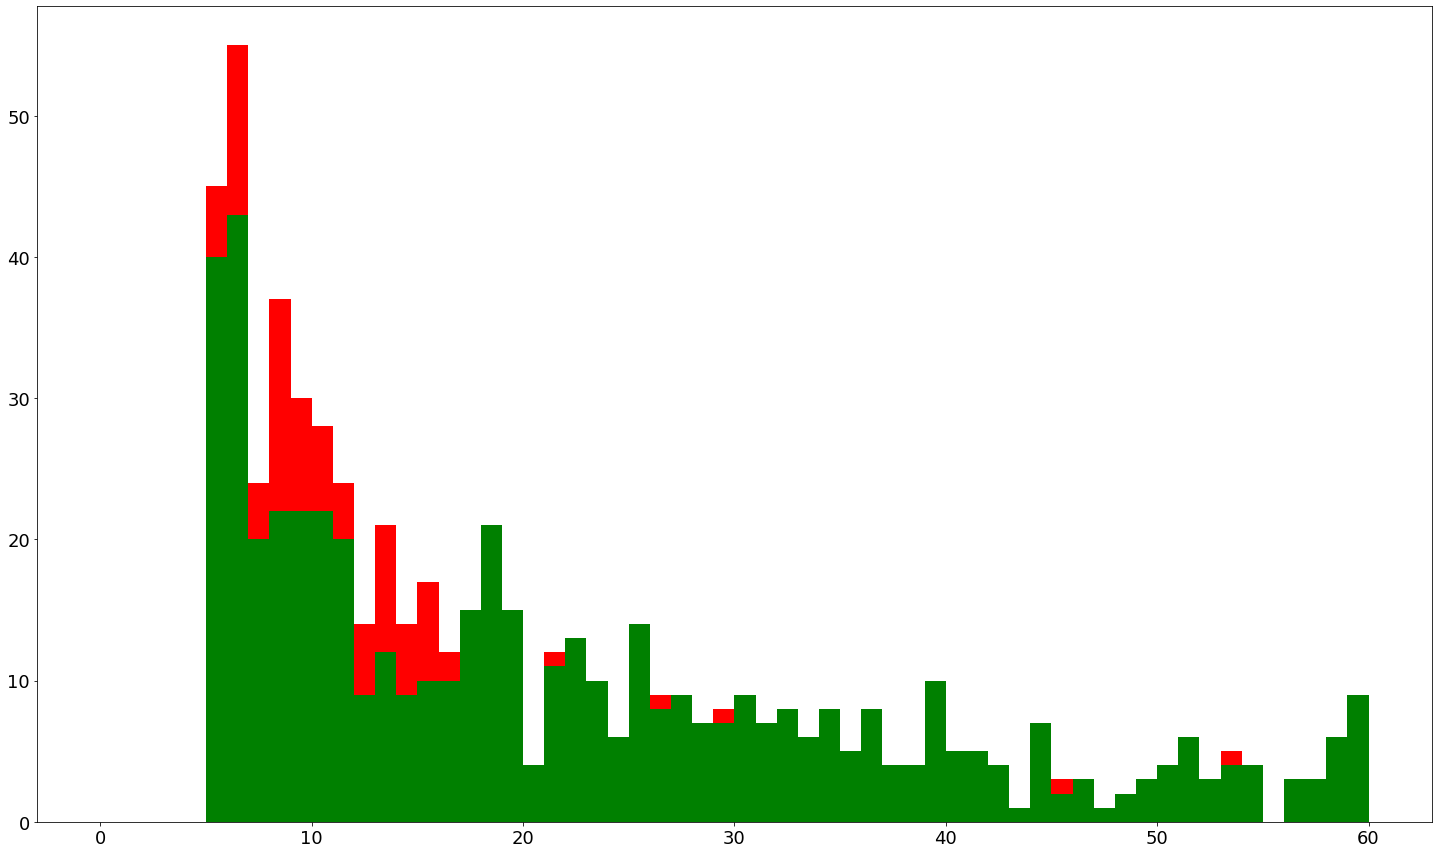

In [20]:
bins = np.linspace(0, 60, 61)
plt.hist(mu.PEDetected_outer+mu.PEDetected_inner, bins=bins, color="red")
plt.hist(mu_tp.PEDetected_outer+mu_tp.PEDetected_inner, bins=bins, color="green")
plt.show()

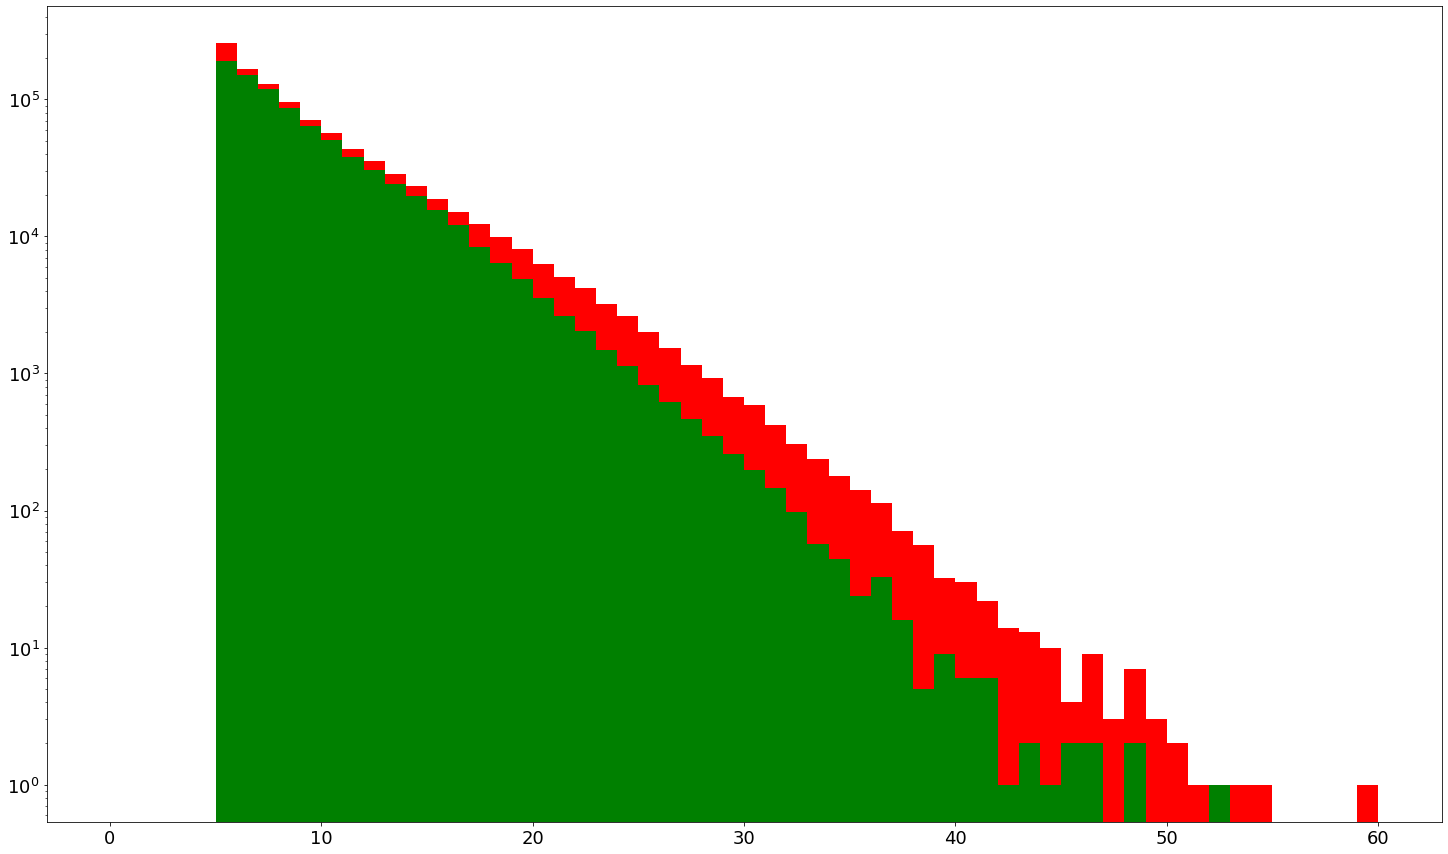

In [21]:
bins = np.linspace(0, 60, 61)
plt.hist(ar.PEDetected_inner+ar.PEDetected_outer, bins=bins, color="red")
plt.hist(ar_tn.PEDetected_inner+ar_tn.PEDetected_outer, bins=bins, color="green")
plt.yscale("log")
plt.show()

In [22]:
test_fpr = fpr / 100
test_tpr = tpr / 100

print("Considering a Test Set ({} Ar39, {} Mu) of events wt {}<=PE<={}".format(len(ar_test_feat), len(mu_test_feat), minPEcut, maxPEar39))
print("FPR: {}, TPR: {}".format(test_fpr, test_tpr))

# Compute efficiency and fpr on all data
ar39_below5, ar39_above5 = len(df_ar39[df_ar39.pedetected<5]), len(ar_test_feat)
ar39_tot = ar39_below5 + ar39_above5
fp = round(ar39_above5 * test_fpr)

mu_below5, mu_5_60, mu_above60 = len(df_mu[df_mu.pedetected<5]), len(mu_test_feat), len(df_mu[df_mu.pedetected>60])
mu_tot = mu_below5 + mu_5_60 + mu_above60
tp = mu_above60 + round(mu_5_60 * test_tpr)
print()
print("Considering the whole sample ({} Ar39, {} Mu) and combining the preliminary cuts".format(ar39_tot, mu_tot))
print("Estimated FPR: {} %".format(fp/ar39_tot*100))
print("Estimated TPR: {} %".format(tp/mu_tot*100))


Considering a Test Set (1000000 Ar39, 610 Mu) of events wt 5<=PE<=60
FPR: 0.164455, TPR: 0.8573770491803279

Considering the whole sample (5834261 Ar39, 26881 Mu) and combining the preliminary cuts
Estimated FPR: 2.8187803048235245 %
Estimated TPR: 82.10260034968937 %


# Train Other models

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn import model_selection

# Prepare data for training
mu_myfeat["y"] = 1
ar39_myfeat["y"] = 0
data = pd.concat([mu_myfeat, ar39_myfeat], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = np.array(X)
y = np.array(y)
# Prepare data for test
mu_test_my_feat = mu_test_feat.loc[:, my_features]
ar_test_my_feat = ar_test_feat.loc[:, my_features]
mu_test_my_feat["y"] = 1
ar_test_my_feat["y"] = 0
test_data = pd.concat([mu_test_my_feat, ar_test_my_feat], axis=0)
X_test, y_test = test_data.iloc[:, :-1], test_data.iloc[:, -1]
X_test = np.array(X_test)
y_test = np.array(y_test)

dfs = []
models = [
          ('LogReg', LogisticRegression()), 
          ('DTtree', DecisionTreeClassifier(max_depth=4, min_samples_leaf=200)),
          ('MLP', MLPClassifier()), 
          ('RF', RandomForestClassifier()),
          ('SVM', SVC()), 
          ('XGB', GradientBoostingClassifier()),
          ('Ada', AdaBoostClassifier())
        ]
trained_models = []
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
target_names = ['ar39', 'mu']

for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X, y, cv=kfold, scoring=scoring)
    clf = model.fit(X, y)
    trained_models.append(clf)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names))
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)

LogReg
              precision    recall  f1-score   support

        ar39       1.00      0.80      0.89   1000000
          mu       0.00      0.89      0.01       610

    accuracy                           0.80   1000610
   macro avg       0.50      0.85      0.45   1000610
weighted avg       1.00      0.80      0.89   1000610

DTtree
              precision    recall  f1-score   support

        ar39       1.00      0.88      0.94   1000000
          mu       0.00      0.86      0.01       610

    accuracy                           0.88   1000610
   macro avg       0.50      0.87      0.47   1000610
weighted avg       1.00      0.88      0.94   1000610

MLP
              precision    recall  f1-score   support

        ar39       1.00      0.79      0.88   1000000
          mu       0.00      0.89      0.01       610

    accuracy                           0.79   1000610
   macro avg       0.50      0.84      0.44   1000610
weighted avg       1.00      0.79      0.88   1000610

R

## Observations:
We are mainly interested on "recall" on Ar39 (TPR). There are

Feature: PEDetected_inner =>	Score: 0.11557
Feature: MeanNPEActive_inner =>	Score: 0.20259
Feature: PEDetected_outer =>	Score: 0.07612
Feature: NActiveSlices_outer =>	Score: 0.58193
Feature: MeanNPEActive_outer =>	Score: 0.00271
Feature: SpatialRange_outer =>	Score: 0.00254
Feature: PEDetected_tot =>	Score: 0.01856


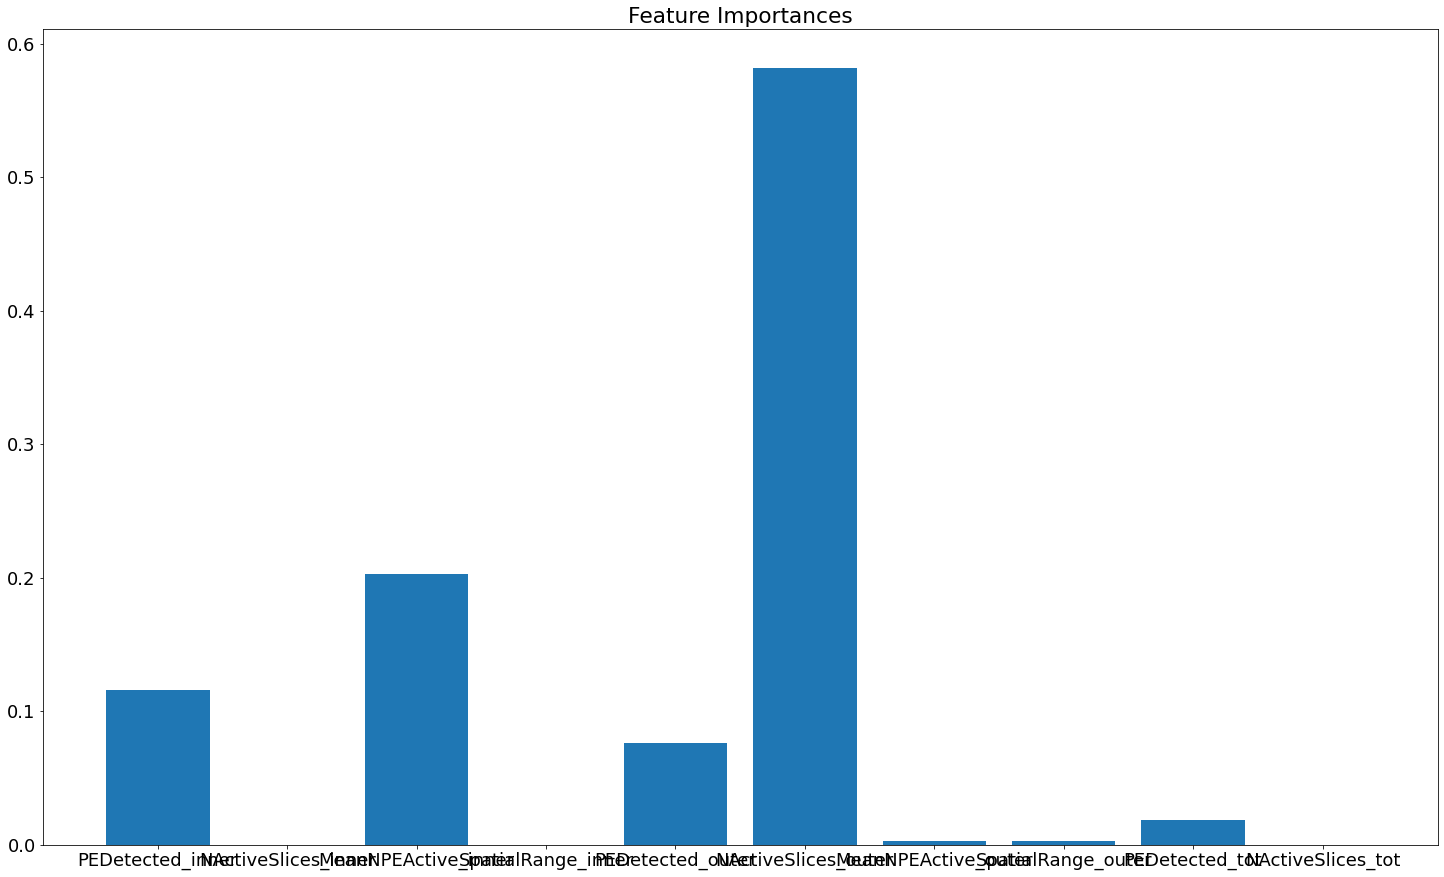

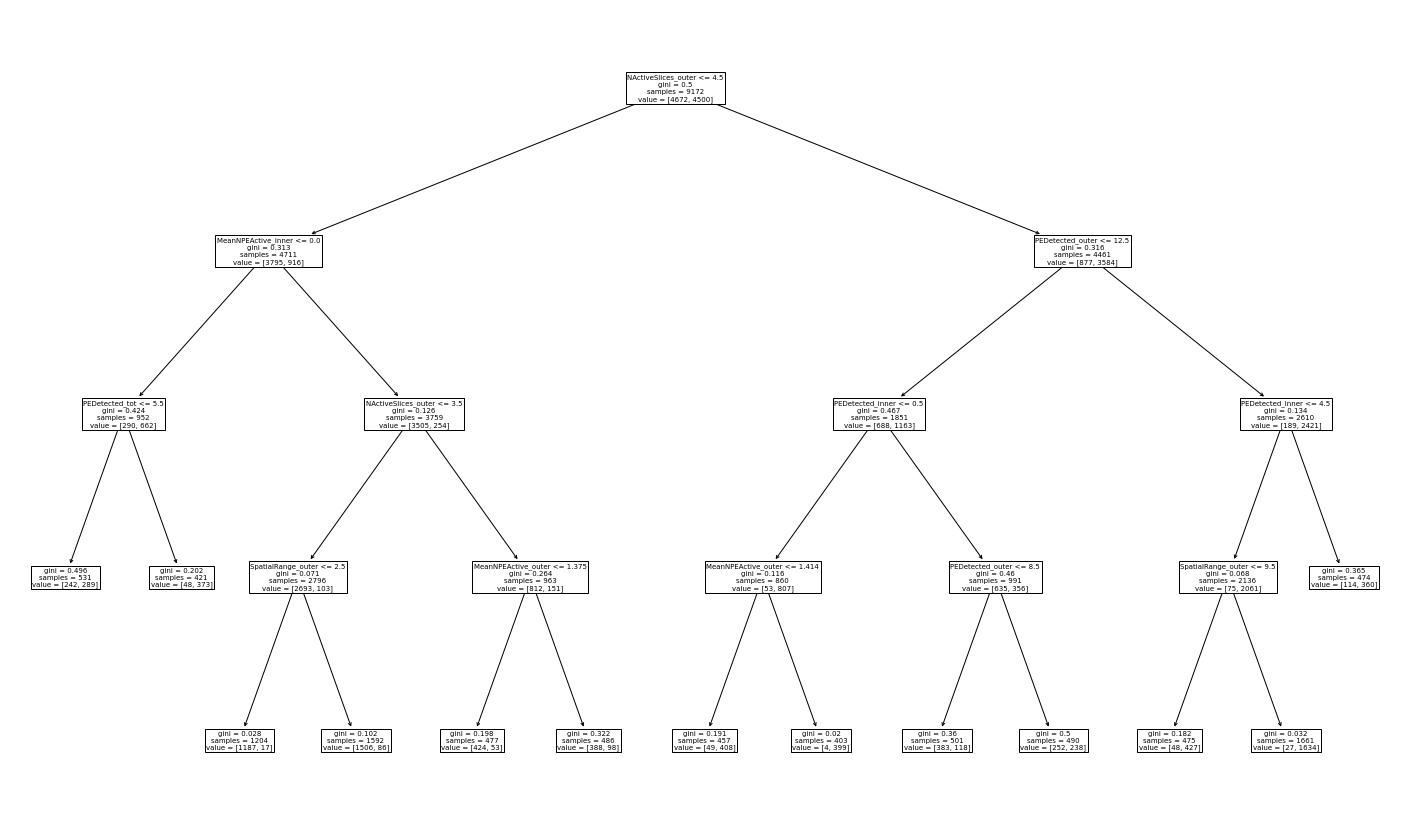

In [100]:
from sklearn import tree
# Train final model
final_clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=400)
final_clf.fit(X, y)

full_feature_names = ar39_myfeat.columns[:-1]
short_feature_names = full_feature_names
# get importance
importances = final_clf.feature_importances_
# summarize feature importance
for i, (name, shortn, v) in enumerate(zip(full_feature_names, short_feature_names, importances)):
    if(v<=0): 
        continue
    print('Feature: %s =>\tScore: %.5f' % (name, v))
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.xticks(range(0, len(short_feature_names)), short_feature_names)
plt.title("Feature Importances")
plt.show()

tree.plot_tree(final_clf, feature_names=ar39_myfeat.columns[:-1])
plt.show()

In [101]:
y_pred = final_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
my_s = my_custom_score_func(y_test, y_pred)
tn, fp, fn, tp = cv(y_test, y_pred).ravel()
tpr, fpr = recall*100, fp/(fp+tn)*100

result_template  = "[Result] {}:\nAccuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}, My Score: {:.3f}\n"
cm_template  =     "[Result] Conf. Matrix: TN: {}, FP: {}, FN: {}, TP: {} | TPR: {:.2f}%, FPR: {:.2f}%\n"


print(result_template.format("Test({} Mu, {} Ar)".format(len(mu_test_feat), len(ar_test_feat)),
                             accuracy, precision, recall, f1, my_s))    
print(cm_template.format(tn, fp, fn, tp, tpr, fpr))    

[Result] Test(610 Mu, 1000000 Ar):
Accuracy: 0.880, Precision: 0.004, Recall: 0.852, F1: 0.009, My Score: 0.880

[Result] Conf. Matrix: TN: 879742, FP: 120258, FN: 90, TP: 520 | TPR: 85.25%, FPR: 12.03%



In [102]:
test_fpr = fpr / 100
test_tpr = tpr / 100

# Compute efficiency and fpr on all data
ar39_below5, ar39_above5 = len(df_ar39[df_ar39.pedetected<5]), len(ar_test_feat)
ar39_tot = ar39_below5 + ar39_above5
fp = round(ar39_above5 * test_fpr)
print("Estimated FPR: {} %".format(fp/ar39_tot*100))

mu_below5, mu_5_60, mu_above60 = len(df_mu[df_mu.pedetected<5]), len(mu_test_feat), len(df_mu[df_mu.pedetected>60])
mu_tot = mu_below5 + mu_5_60 + mu_above60
tp = mu_above60 + round(mu_5_60 * test_tpr)
print("Estimated TPR: {} %".format(tp/mu_tot*100))


Estimated FPR: 2.0612379185641507 %
Estimated TPR: 82.09144005059336 %


# Test on all data (whole PE range)

In [135]:
import time

init = time.time()
all_mu_feat = pd.DataFrame()
all_mu_feat["PEDetected_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
all_mu_feat["NActiveSlices_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
all_mu_feat["MeanNPEActive_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
all_mu_feat["StdNPEActive_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
all_mu_feat["SpatialRange_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
all_mu_feat["SpatialVar_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
all_mu_feat["SpatialStd_inner"] = df_mu.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
all_mu_feat["PEDetected_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
all_mu_feat["NActiveSlices_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
all_mu_feat["MeanNPEActive_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
all_mu_feat["StdNPEActive_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
all_mu_feat["SpatialRange_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
all_mu_feat["SpatialVar_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
all_mu_feat["SpatialStd_outer"] = df_mu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
all_mu_feat["PEDetected_tot"] = all_mu_feat["PEDetected_inner"] + all_mu_feat["PEDetected_outer"]
all_mu_feat["NActiveSlices_tot"] = all_mu_feat["NActiveSlices_inner"] + all_mu_feat["NActiveSlices_outer"]
all_mu_feat["MeanNPEActive_tot"] = all_mu_feat["PEDetected_tot"] / all_mu_feat["NActiveSlices_tot"]
all_mu_feat = all_mu_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 5.572 sec
Compute Mu Outer features: 6.993 sec
Compute combined features: 0.006 sec


In [147]:
import time

init = time.time()
all_ar39_feat = pd.DataFrame()
all_ar39_feat["PEDetected_inner"] = df_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
all_ar39_feat["NActiveSlices_inner"] = df_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
all_ar39_feat["MeanNPEActive_inner"] = df_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
all_ar39_feat["StdNPEActive_inner"] = df_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
all_ar39_feat["SpatialRange_inner"] = df_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
all_ar39_feat["SpatialVar_inner"] = df_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
all_ar39_feat["SpatialStd_inner"] = df_ar39.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
all_ar39_feat["PEDetected_outer"] = df_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
all_ar39_feat["NActiveSlices_outer"] = df_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
all_ar39_feat["MeanNPEActive_outer"] = df_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
all_ar39_feat["StdNPEActive_outer"] = df_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
all_ar39_feat["SpatialRange_outer"] = df_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
all_ar39_feat["SpatialVar_outer"] = df_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
all_ar39_feat["SpatialStd_outer"] = df_ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Ar Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()

Compute Ar Inner features: 697.777 sec
Compute Ar Outer features: 1178.312 sec


ValueError: cannot reindex from a duplicate axis

In [152]:
init = time.time()
all_ar39_feat["PEDetected_tot"] = all_ar39_feat["PEDetected_inner"] + all_ar39_feat["PEDetected_outer"]
all_ar39_feat["NActiveSlices_tot"] = all_ar39_feat["NActiveSlices_inner"] + all_ar39_feat["NActiveSlices_outer"]
all_ar39_feat["MeanNPEActive_tot"] = all_ar39_feat["PEDetected_tot"] / all_ar39_feat["NActiveSlices_tot"]
all_ar39_feat = all_ar39_feat.fillna(-1)
print("Compute Ar combined features: {:.3f} sec".format(time.time() - init))

Compute Ar combined features: 0.876 sec


In [154]:
all_mu_test_my_feat = all_mu_feat.loc[:, my_features]
all_ar39_test_my_feat = all_ar39_feat.loc[:, my_features]
all_mu_test_my_feat["y"] = 1
all_ar39_test_my_feat["y"] = 0
all_data = pd.concat([all_mu_test_my_feat, all_ar39_test_my_feat], axis=0)
X_mutest, y_mutest = all_data.iloc[:, :-1], all_data.iloc[:, -1]
X_mutest = np.array(X_mutest)
y_mutest = np.array(y_mutest)

In [165]:
y_pred = final_clf.predict(X_mutest)
recall = recall_score(y_mutest, y_pred)
tn, fp, fn, tp = cv(y_mutest, y_pred).ravel()
tpr = recall*100

all_data["y_pred"] = y_pred
mu = all_data[(all_data.y==1)]
mu_tp = all_data[(all_data.y==1) & (all_data.y_pred==1) & (all_data.PEDetected_tot>=5)]
mu_fn = all_data[(all_data.y==1) & ((all_data.y_pred==0) | (all_data.PEDetected_tot<5))]
ar39 = all_data[(all_data.y==0)]
ar39_tn = all_data[(all_data.y==0) & ((all_data.y_pred==0) | (all_data.PEDetected_tot<5))]
ar39_fp = all_data[(all_data.y==0) & (all_data.y_pred==1) & (all_data.PEDetected_tot>=5)]

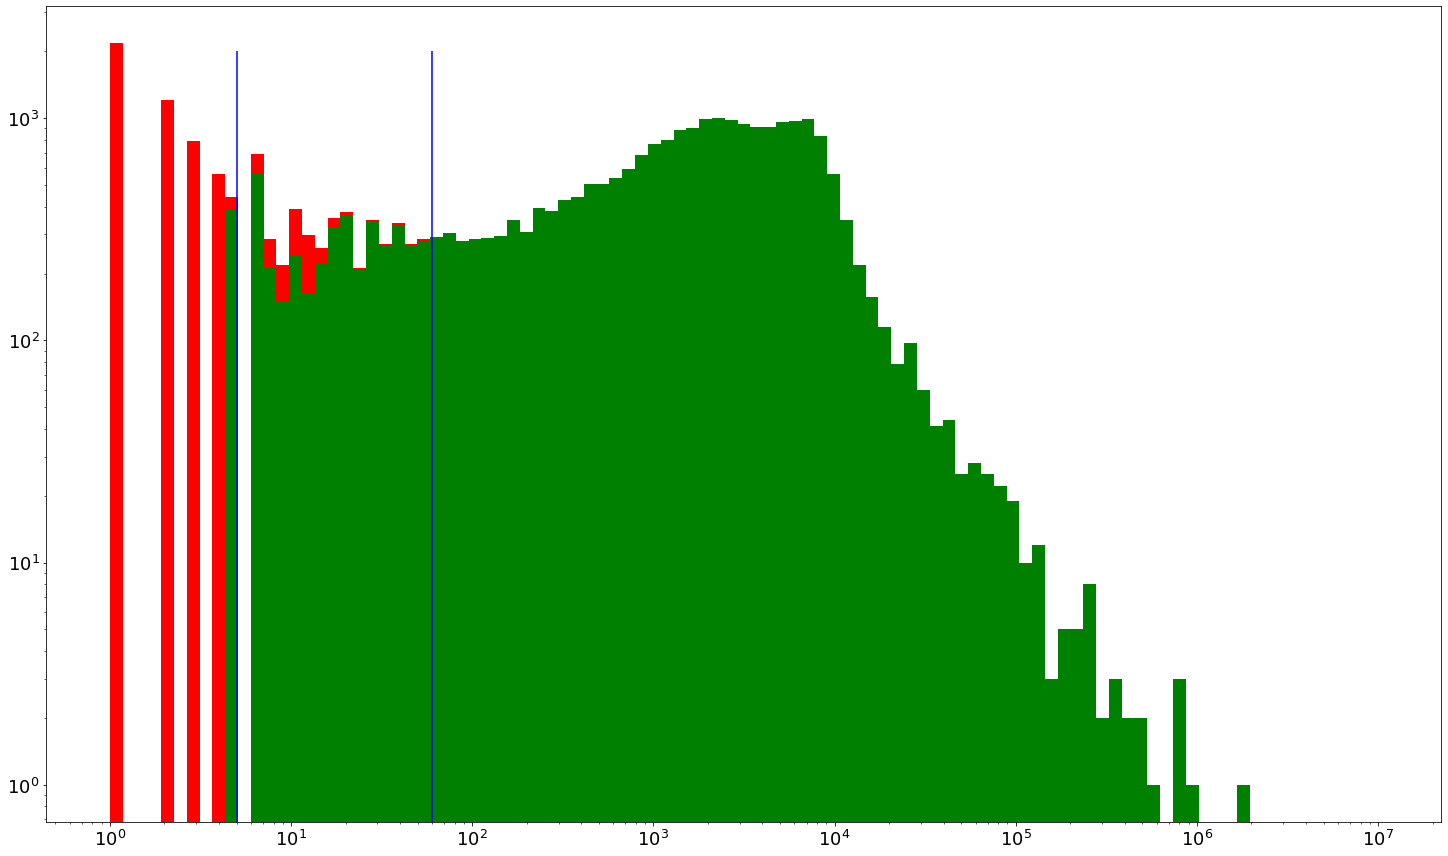

In [166]:
bins = np.logspace(0, 7, 100)
plt.hist(mu.PEDetected_outer+mu.PEDetected_inner, bins=bins, color="red", label="Rejected")
plt.hist(mu_tp.PEDetected_outer+mu_tp.PEDetected_inner, bins=bins, color="green", label="Accepted")
plt.vlines(x=5, ymin=0, ymax=2000, color="b", label="5PE")
plt.vlines(x=60, ymin=0, ymax=2000, color="b", label="60PE")
plt.xscale("log")
plt.yscale("log")
plt.show()

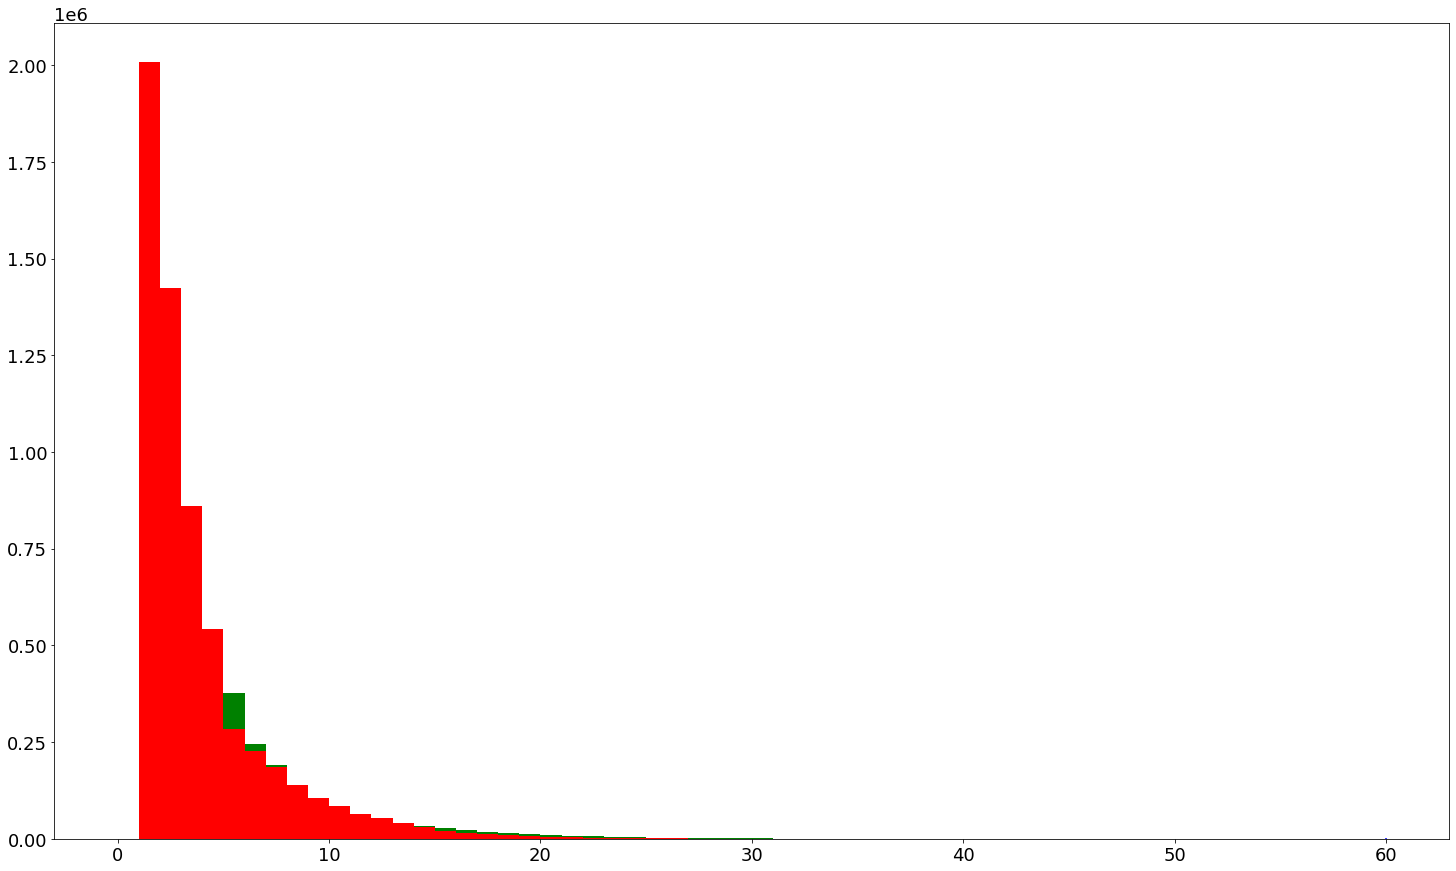

In [167]:
bins = np.linspace(0, 60, 61)
plt.hist(ar39.PEDetected_outer+ar39.PEDetected_inner, bins=bins, color="green", label="Accepted")
plt.hist(ar39_tn.PEDetected_outer+ar39_tn.PEDetected_inner, bins=bins, color="red", label="Rejected")
plt.vlines(x=60, ymin=0, ymax=2000, color="b", label="60PE")
plt.show()

In [176]:
1 - len(ar39_tn)/len(ar39)

0.02812687184505691

# TODO SAVE MODEL TO DISK

In [171]:
from joblib import dump, load
dump(final_clf, 'dtree_trained_npe5_60_09lug2020.joblib'.format())

['dtree_trained_npe5_60_09lug2020.joblib']